In [1]:
# Base module
import dolfinx as _dolfinx
from dolfinx import mesh as _mesh
from dolfinx import fem as _fem
from dolfinx import nls as _nls

import numpy as _np
import ufl as _ufl


# Operators
class _Infix:
    """Create infix function from default"""

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return _Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = _Infix(_ufl.dot)
inner = _Infix(_ufl.inner)

npor = _Infix(_np.logical_or)
npand = _Infix(_np.logical_and)


def vector(*args):
    return _ufl.as_vector(tuple(args))


def I(func_like):
    """Create matrix Identity dimension of func_like

    Args:
        func_like (Function): Give geometric dimension

    Returns:
        Tensor: Identity
    """
    return _ufl.Identity(func_like.geometric_dimension())


# Functions:
def get_space_dim(space):
    """Get dimensions of X on space

    Args:
        space (fem.FunctionSpace): Space

    Returns:
        List: space dim, len
    """
    return (space.mesh.geometry.dim, len(space.dofmap.list.array))


def create_FacetTags_boundary(domain, bound_markers):
    """Mark boundary facets under conditious

    Args:
        domain (Domain): Domain
        bound_markers (mark,python_function): List of mark and function

    Return:
        tags(mesh.meshtags): Marked facets
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = _mesh.locate_entities_boundary(
            domain,
            domain.topology.dim - 1,
            condition,
            )
        facet_indices.append(facets)
        facet_markers.append(_np.full_like(facets, marker))
    facet_indices = _np.hstack(facet_indices).astype(_np.int32)
    facet_markers = _np.hstack(facet_markers).astype(_np.int32)
    sorted_facets = _np.argsort(facet_indices)
    facet_tags = _mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
        )

    return facet_tags


def create_connectivity(domain):
    """Need to compute facets to Boundary value

    Args:
        domain (Mesh): Domain
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )


# Classes
def DirichletBC(space, form, combined_marker):
    """Create Dirichlet condition. For several spaces:: first space is general.

    Args:
        space (fem.FunctionSpace): Function space
        func (fem.function): Function only
        combined_marker (Any): One from next::
        \nFunction - boundary marker function find geometrical
        \nAll - all boundary find entities
        \n(mesh.meshtags, marker) -Find entities marker of boundary from mesh tags

    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def all_dirichlet(dofs, form, space):
        if hasattr(form, 'function_space'):
            if form.function_space == space:
                bc = _fem.dirichletbc(dofs=dofs, value=form)
            else:
                bc = _fem.dirichletbc(V=space, dofs=dofs, value=form)
        else:
            bc = _fem.dirichletbc(V=space, dofs=dofs, value=form)
        return bc

    if isinstance(space, tuple or list): space0 = space[0]
    else: space0 = space
    domain = space0.mesh

    if combined_marker == 'All':
        facets = _mesh.exterior_facet_indices(domain.topology)
        dofs = _fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    elif isinstance(combined_marker, tuple or list):
        marked_facets, marker = combined_marker
        facets = marked_facets.find(marker)
        dofs = _fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    else:
        dofs = _fem.locate_dofs_geometrical(space, combined_marker)

    bc = all_dirichlet(dofs, form, space0)

    return bc


def Function(space, form=None):
    """Function on new space. Default = 0

    Args:
        space (FunctionSpace): New space
        form (): Any form:
        \nScalars - fem.Function,fem.Constant, ufl_function, callable function, number
        \nVectors - fem.vector_Function, fem.vector_Constant, ufl_vector_function,
        callable vector_function, tuple_number

    Returns:
        fem.Function: Function
    """

    def interpolate(function, form):
        """Interpolate form to function

        Args:
            function (fem.Function): _description_
            form (any form):
            \nScalars - fem.Function,fem.Constant, ufl_function, callable function, number
            \nVectors - fem.vector_Function, fem.vector_Constant, ufl_vector_function,
            callable vector_function, tuple_number

        Returns:
            fem.Function: Interpolated fem.Function
        """
        space = function.function_space

        tupe = str(form.__class__)[8:-2]
        cord = _ufl.SpatialCoordinate(space)

        # fem.Function
        if tupe == ('dolfinx.fem.function.Function'):
            expression = form

        # fem.Constant
        elif tupe == ('dolfinx.fem.function.Constant'):
            if len(form.ufl_shape) == 0:
                form2 = form.value + (cord[0] - cord[0])
            else:
                form2 = vector(*form.value) +\
                    vector(*map(lambda x, y: x - y, cord, cord))
            expression = _fem.Expression(
                form2, space.element.interpolation_points()
                )

        # ufl object
        elif tupe[:3] == 'ufl':
            if len(form.ufl_shape) != 0:
                form2 = form + vector(*map(lambda x, y: x - y, cord, cord))
            else:
                form2 = form + (cord[0] - cord[0])
            expression = _fem.Expression(
                form2, space.element.interpolation_points()
                )

        # Python function
        elif hasattr(form, '__call__'):
            expression = form

        # Number
        elif not hasattr(form, '__call__'):
            if hasattr(form, '__getitem__'):
                form2 = vector(*form
                               ) + vector(*map(lambda x, y: x - y, cord, cord))
            else:
                form2 = form + (cord[0] - cord[0])
            expression = _fem.Expression(
                form2, space.element.interpolation_points()
                )
        function.interpolate(expression)
        return function

    function = _fem.Function(space)

    if form is None:
        return function
    else:
        interpolate(function=function, form=form)

    return function


def Constant(domain_space, const):
    """Constant on space

    Args:
        space (fem.FunctionSpace| domain): Space or domain
        const (auny number): Any number

    Returns:
        fem.function.Constant: Constant on space
    """
    return _fem.Constant(domain_space, _fem.petsc.PETSc.ScalarType(const))


# Solvers
class LinearProblem:
    """Create linear (nonlinear) problem

        Args:
            a (ufl.Form): bilinear form
            L (ufl.Form): linear form
            bcs (Dirichlet): Dirichlet conditious.
            u (fem.Function): Function to be solved.
            \npetsc_options (dict): Options to petsc.
            Defaults to { 'ksp_type': 'preonly', 'pc_type': 'lu' }.
            \nassemble_options (dict): Options to assemble bilinear and linear forms.
            Defaults to {'assebmle_A': True, 'assemble_B': True}.
            \nghost_opions (dict): GhostUpdate potions.
            Defaults to  {'addv': ADD,'mode': REVERSE}.
            \nform_compiler_params (dict): Form compiler options.
            Defaults to {}.
            \njit_params (dict): JIT parmetrs.
            Defaults to {}.
        """

    def __init__(
        self,
        a: _ufl.Form,
        L: _ufl.Form,
        bcs: list,
        u: _fem.Function,
        petsc_options={
            'ksp_type': 'preonly', 'pc_type': 'lu'
            },
        assemble_options={
            'assemble_A': True, 'assemble_b': True
            },
        ghost_opions={},
        form_compiler_params={},
        jit_params={},
        ):
        # FIXME: Maybe need setiings options to forms or not?
        def set_options(self, petsc_options):
            ksp = self._solver
            problem_prefix = f'dolfinx_solve_{id(self)}'
            ksp.setOptionsPrefix(problem_prefix)
            opts = _fem.petsc.PETSc.Options()
            opts.prefixPush(problem_prefix)
            for k, v in petsc_options.items():
                opts[k] = v
            opts.prefixPop()
            ksp.setFromOptions()
            # self._A.setOptionsPrefix(problem_prefix)
            # self._A.setFromOptions()
            # self._b.setOptionsPrefix(problem_prefix)
            # self._b.setFromOptions()
            pass

        self._u = u
        self.bcs = bcs

        # A form
        self._a = _fem.form(
            a,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
            )
        self._A = _fem.petsc.create_matrix(self._a)

        # b form
        self._L = _fem.form(
            L,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
            )
        self._b = _fem.petsc.create_vector(self._L)

        # Creating solver
        self._solver = _fem.petsc.PETSc.KSP().create(
            self._u.function_space.mesh.comm
            )
        self._solver.setOperators(self._A)
        set_options(self, petsc_options)

        # Another options
        self._ghost_opions = {
            'addv': _fem.petsc.PETSc.InsertMode.ADD,
            'mode': _fem.petsc.PETSc.ScatterMode.REVERSE,
            }
        self._ghost_opions.update(ghost_opions)

        # Assembling
        if assemble_options['assemble_A']: self.assemble_A()
        if assemble_options['assemble_b']: self.assemble_b()

    def assemble_A(self):
        """Assemle bilinear form"""
        self._A.zeroEntries()
        _fem.petsc._assemble_matrix_mat(self._A, self._a, bcs=self.bcs)
        self._A.assemble()

    def assemble_b(self):
        """Assemble linear form"""
        with self._b.localForm() as b_loc:
            b_loc.set(0)
        _fem.petsc.assemble_vector(self._b, self._L)
        _fem.petsc.apply_lifting(self._b, [self._a], bcs=[self.bcs])
        self._b.ghostUpdate(
            addv=self._ghost_opions['addv'],
            mode=self._ghost_opions['mode'],
            )
        _fem.petsc.set_bc(self._b, self.bcs)

    def solve(self):
        """Solve function

        Returns:
            fem.Function: Solved function
        """
        result = self._solver.solve(self._b, self._u.vector)
        self._u.x.scatter_forward()
        return result

    @staticmethod
    def KSP_types():
        """Get KSP types"""
        return _fem.petsc.PETSc.KSP.Type

    @staticmethod
    def PC_types():
        """Get PC types"""
        return _fem.petsc.PETSc.PC.Type

    @staticmethod
    def ghost_updates():
        """Get ghost_update types"""
        return (_fem.petsc.PETSc.InsertMode, _fem.petsc.PETSc.ScatterMode)

    @property
    def L(self) -> _fem.FormMetaClass:
        """The compiled linear form"""
        return self._L

    @property
    def a(self) -> _fem.FormMetaClass:
        """The compiled bilinear form"""
        return self._a

    @property
    def A(self) -> _fem.petsc.PETSc.Mat:
        """Matrix operator"""
        return self._A

    @property
    def b(self) -> _fem.petsc.PETSc.Vec:
        """Right-hand side vector"""
        return self._b

    @property
    def solver(self) -> _fem.petsc.PETSc.KSP:
        """Linear solver object"""
        return self._solver


class NonlinearProblem:
    """Create nonlinear problem

        Args:
            F (ufl.Form): Nonlinear equation form
            bcs (Dirichlet): Dirichlet conditious.
            u (fem.Function): Function to be solved.
            \nJ (ufl.Form): Jacobian matrix. Defaults None.
            \npetsc_options (dict): Options to petsc. Defaults to {
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps',
            }.
            \nsolve_options (dict): Options to NEwton solwer.
            Defaults to {'convergence': 'incremental', 'tolerance': 1E-6}.
            \nghost_opions (dict):  You cant change it
            {'addv': INSERT,'mode': FORWARD}
            \nform_compiler_params (dict): Form compiler options.
            Defaults to {}.
            \njit_params (dict): JIT parmetrs.
            Defaults to {}.
        """

    def __init__(
        self,
        F: _ufl.Form,
        bcs: list,
        u: _fem.Function,
        J: _ufl.Form = None,
        solve_options={
            'convergence': 'incremental', 'tolerance': 1E-6
            },
        petsc_options={
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps',
            },
        form_compiler_params={},
        jit_params={},
        ):

        def set_options(self, petsc_options, solve_options):
            self._solver.convergence_criterion = solve_options['convergence']
            self._solver.rtol = solve_options['tolerance']

            ksp = self._solver.krylov_solver
            problem_prefix = ksp.getOptionsPrefix()
            opts = _fem.petsc.PETSc.Options()
            opts.prefixPush(problem_prefix)
            for k, v in petsc_options.items():
                opts[k] = v
            ksp.setFromOptions()

        self._u = u
        self.bcs = bcs

        pr = _fem.petsc.NonlinearProblem(
            F=F,
            u=self._u,
            bcs=self.bcs,
            J=J,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
            )
        self._a = pr.a
        self._L = pr.L

        # Creating solver
        self._solver = _nls.petsc.NewtonSolver(
            self._u.function_space.mesh.comm,
            pr,
            )
        set_options(
            self, petsc_options=petsc_options, solve_options=solve_options
            )

    def solve(self):
        """Solve function

        Returns:
            fem.Function: Solved function
        """
        result = self._solver.solve(self._u)
        return result

    @staticmethod
    def KSP_types():
        """Get KSP types"""
        return _fem.petsc.PETSc.KSP.Type

    @staticmethod
    def PC_types():
        """Get PC types"""
        return _fem.petsc.PETSc.PC.Type

    @property
    def solver(self) -> _fem.petsc.PETSc.KSP:
        """Linear solver object"""
        return self._solver

    @property
    def L(self) -> _fem.FormMetaClass:
        """The compiled linear form"""
        return self._L

    @property
    def a(self) -> _fem.FormMetaClass:
        """The compiled bilinear form"""
        return self._a


# Post process
class PostProcess:
    """Class for different methods to plot functions"""

    @staticmethod
    def data_construct(dofs, x_array):
        """Constuct X data

        Args:
            dofs (fem.dofs): Dofs
            x_array (fem.array): X array

        Returns:
            np.array: Data
        """
        data = _np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    @staticmethod
    def line_collision(domain, line_cord):
        """Generate points and cells of colliding domain and line

        Args:
            domain (mesh): Domain
            line_cord (array): 3D line contervertor of coordinates

        Returns:
            Tuple: Collision points and collision cells
        """
        bb_tree = _dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells_on_line = []
        points_on_line = []
        cell_candidates = _dolfinx.geometry.compute_collisions(
            bb_tree, line_cord.T
            )
        colliding_cells = _dolfinx.geometry.compute_colliding_cells(
            domain, cell_candidates, line_cord.T
            )
        for i, point in enumerate(line_cord.T):
            if len(colliding_cells.links(i)) > 0:
                points_on_line.append(point)
                cells_on_line.append(colliding_cells.links(i)[0])

        points_on_line = _np.array(points_on_line, dtype=_np.float64)

        return (points_on_line, cells_on_line)

    @staticmethod
    def graph1D(fig, ax, lists, points_on=False):
        """Create graph from fem.Function

        Args:
            fig (plt.Figure): Figure
            lists (fem.Function, str): List of (u, title)
            points_on (bool): If true create scatter
        """
        tol = 0.000001
        num_points = 100
        for lis in lists:
            u, title = lis
            domain = u.function_space.mesh
            x_dofs = u.function_space.tabulate_dof_coordinates()[:, 0]
            x_min = min(x_dofs)
            x_max = max(x_dofs)

            line = _np.zeros((3, num_points + 1))
            line[0] = _np.linspace(x_min + tol, x_max - tol, num_points + 1)
            collision_line = PostProcess.line_collision(
                domain=domain,
                line_cord=line,
                )
            line[1] =u.eval(*collision_line)[:,0]
            ax.set_title(title)
            if points_on: ax.scatter(line[0], line[1])
            ax.plot(line[0], line[1], label=title)

        ax.legend(loc='upper left', facecolor='yellow')
        return

    @staticmethod
    def graph2D(fig, lists, natural_show=False, points_on=False):
        """Create graph from fem.Function

        Args:
            fig (plt.Figure): Figure
            lists (fem.Function , plt.Axes, str): List of (u, curent axes, title)
            natural_show (bool): True = tripcolor, False = tricontourf
            points_on (bool): True = set points
        """

        for lis in lists:
            u, ax, title = lis
            dofs = u.function_space.tabulate_dof_coordinates()
            ax.set_title(title)
            data = PostProcess.data_construct(dofs, u.x.array)

            if points_on:
                ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

            if natural_show:
                plot = ax.tripcolor(*data)
            else:
                try:
                    levels = _np.linspace(u.x.array.min(), u.x.array.max(), 10)
                    plot = ax.tricontourf(*data, levels=levels)
                except:
                    print(f'{title} - error')

            ax.set_aspect(1)
            fig.colorbar(plot, ax=ax)
        return

    @staticmethod
    def L1_error(space, u0, u1):
        """L1 error

        Args:
            space (fem.Space): Space
            u0 (fem.Function): Default function
            u1 (fem.Function): Compare function

        Returns:
            fem.Function: L1 error
        """
        L1 = Function(space, abs(u1 - u0))
        return L1


In [2]:
# Saving and type checking
import shutil
import typing
# Solving
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import FunctionSpace, VectorFunctionSpace
from mpi4py import MPI
import numpy as np

# Operators
import ufl
from ufl import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from ufl import FacetNormal, SpatialCoordinate, variable
from ufl import diff as D
from ufl import nabla_div, nabla_grad, grad, div
from ufl import as_matrix as matrix
from ufl import lhs, rhs, split
from ufl import exp, sym, tr, sqrt, ln, sin, cos
# Graphics
import matplotlib.pyplot as plt
# Logging
from tqdm import tqdm

In [3]:
N=100

In [4]:
domain = mesh.create_unit_interval(
    nx=N,
    comm=MPI.COMM_WORLD
    )

el = ufl.FiniteElement(family='CG', cell=domain.ufl_cell(), degree=2)
Mix_el = el * el
W = FunctionSpace(mesh=domain, element=Mix_el)
W0, _ = W.sub(0).collapse()
W1, _ = W.sub(1).collapse()

x = SpatialCoordinate(W)[0]
dx = ufl.Measure('cell', subdomain_id='everywhere')
ds = ufl.Measure("ds", domain=domain)
u, v = TestFunctions(W)
s, s0 = Function(W), Function(W)

cN, cP = split(s)
cN0, cP0 = split(s0)
cNS = s.sub(0)
cPS = s.sub(1)
cNS.name = 'Cneutral'
cPS.name = 'Cpolimer'

In [5]:
n_steps = 100

# dt = 0.001
# T = n_steps * dt
# # OR
T = 2
dt = T / n_steps

n_shecks = 20
check_every = int(n_steps / n_shecks)

cN0_f = Function(W0,0.2)
cP0_f = Function(W1,1E-4)

gamma = 4

light_f = lambda x: np.where(
        npand(x[0] <= 0.4, x[0] >= 0.2),
    1,
    0,
    )

save_dir = '/home/VTK/System1D_files'
num_save = '2'

In [6]:
s.sub(0).interpolate(cN0_f)
s.sub(1).interpolate(cP0_f)
# s.x.scatter_forward()

light = Function(W1, light_f)
light.name = 'Light'
# light.x.scatter_forward()

In [7]:
# # Nonconcervative task

# p1 = 0.13
# a1 = 0.1
# e1 = 0.1*a1 * exp(-cP / p1)
# b1 = 0.1*a1 * exp(-cP / p1)
# f = gamma * (1-cP-cN) * (-ln((1-cP-cN) / (1-cN)))**((gamma-1) / gamma)

# F1 = (1/dt) * (cN-cN0) * u * dx
# F1 += a1 * (grad(cN)|dot|grad(u)) * dx
# F1 += -a1 * cP * (grad(cN)|dot|grad(u)) * dx
# F1 += a1 * cN * (grad(cP)|dot|grad(u)) * dx
# F1 += e1 * cP * (grad(cN)|dot|grad(u)) * dx
# F1 += -e1 * cN * (grad(cP)|dot|grad(u)) * dx
# F1 += (e1/p1) * cP * (grad(cP)|dot|grad(cN)) * u * dx
# F1 += -(e1 / p1) * cN * (grad(cP)|dot|grad(cP)) * u * dx

# F2 = (1/dt) * (cP-cP0) * v * dx
# F2 += b1 * (grad(cP)|dot|grad(v)) * dx
# F2 += b1 * cP * (grad(cN)|dot|grad(v)) * dx
# F2 += -b1 * cN * (grad(cP)|dot|grad(v)) * dx
# F2 += -e1 * cP * (grad(cN)|dot|grad(v)) * dx
# F2 += e1 * cN * (grad(cP)|dot|grad(v)) * dx
# F2 += (b1/p1) * cP * (grad(cP)|dot|grad(cN)) * v * dx
# F2 += -(b1 / p1) * cN * (grad(cP)|dot|grad(cP)) * v * dx
# F2 += -(e1 / p1) * cP * (grad(cN)|dot|grad(cP)) * v * dx
# F2 += (e1/p1) * cN * (grad(cP)|dot|grad(cP)) * v * dx
# F2 += (b1/p1) * (grad(cP)|dot|grad(cP)) * v * dx
# F2 += -light * f * v * dx

# F = F1 + F2

In [8]:
# Concervative task
k=1
ka = k*Constant(W0, 0.01)
kb = k*Constant(W0, 1)
ke = k*Constant(W0, 1)

p1 = 0.13
a = ka
b = kb * exp(-cP / p1)
e = ke * exp(-cP / p1)

gN = Constant(W0, 0)
gP = Constant(W1, 0)
f = gamma * (1-cP-cN) * (-ln((1-cP-cN) / (1-cN)))**((gamma-1) / gamma)

qN = -a * grad(cN) + a * cP * grad(cN) - e * cP * grad(cN)
qN += -a * cN * grad(cP) + e * cN * grad(cP)

qP = -b * grad(cP) + b * cN * grad(cP) - e * cN * grad(cP)
qP += -b * cP * grad(cN) + e * cP * grad(cN)

F1 = (1/dt) * (cN-cN0) * u * dx
F1 += -(qN|inner|grad(u)) * dx
# F1 += u * gN * ds

F2 = (1/dt) * (cP-cP0) * v * dx
F2 += -(qP|dot|grad(v)) * dx
# F2 += v * gP * ds
F2 += -light* f * v * dx

F = F1 + F2

In [9]:
problem = NonlinearProblem(
    F=F,
    bcs=[],
    u=s,
    petsc_options={
        'ksp_type': 'cg',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'superlu_dist',
        }
    )

In [10]:
# try:
#     shutil.rmtree(save_dir)
# except:
#     print('Directory empty yet')

In [11]:
with io.XDMFFile(
    domain.comm, save_dir + f'/System{num_save}.xdmf', 'w'
    ) as file:
    file.write_mesh(domain)
    time = 0
    file.write_function(cNS, 0)
    file.write_function(cPS, 0)
    file.write_function(light, 0)
    s0.interpolate(s)

    step_line = tqdm(
        desc='Solving PDE:0',
        iterable=np.arange(0, n_steps, dtype=int),
        )
    for step in step_line:
        
        problem.solve()
        s0.interpolate(s)
        if step % check_every == 0:
            file.write_function(cNS, time + dt)
            file.write_function(cPS, time + dt)
            file.write_function(light, time + dt)
        time += dt

Solving PDE:0: 100%|██████████| 100/100 [00:01<00:00, 86.37it/s]


Norm of polimer: 1.41
Norm of neutral: 2.84


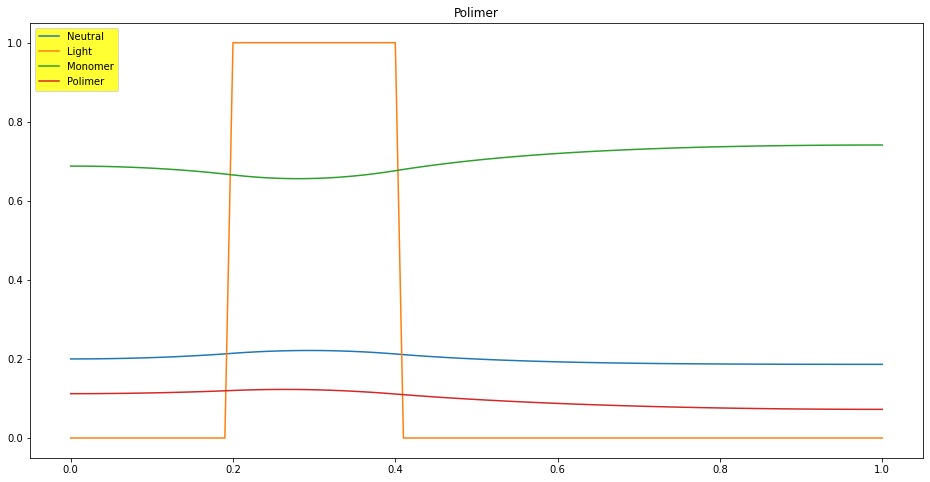

In [12]:
light_col = Function(W0, light)
cNS_col = Function(W0, cNS)
cPS_col = Function(W0, cPS)
cMS_col = Function(W0, 1 - cNS_col - cPS_col)

# print(f'(FDM1) CFL: {alpha*N**2*dt}')
print(f"Norm of polimer: {cPS_col.x.norm():.2f}")
print(f"Norm of neutral: {cNS_col.x.norm():.2f}")
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
PostProcess.graph1D(
    fig=fig,
    ax=ax,
    lists=[
        [cNS_col, 'Neutral'],
        [light_col,'Light'],
        [cMS_col, 'Monomer'],
        [cPS_col, 'Polimer'],
        
        ],    
    # points_on=True,
    )

In [101]:
import re as _re


class Translator:

    @staticmethod
    def replace(subs_dict, text):

        def _multisub(match_obj):
            return str(subs_dict[match_obj.group()])

        multisub_re = _re.compile("|".join(subs_dict.keys()))
        return multisub_re.sub(_multisub, text)

    @staticmethod
    def create_rule(table):
        table = table.replace('\n', '')
        table = table.split('\t')
        if table[-1] == '': table.pop(-1)
        rule = {}
        for i in range(len(table)):
            if i % 2 == 0:
                rule.update({table[i]: table[i + 1]})
        return rule

In [102]:
gen_str = 'if(tcs.nxmesh*tcs.rho*tcs.u<0,tcs.DTestgradcn_w2*tcs.cjump_w2+tcs.Dgradcn_w2*test(w2)-tcs.jump_pen_w2*tcs.cjump_w2*test(w2)+tcs.upwind_w2*test(w2),0)*tcs.d'
rule_str='''tcs.wbnd_w2	0.1	
tcs.cjump_w2	w2-tcs.wbnd_w2	
tcs.jump_pen_w2	4*root.comp1.tcs.open1.Dphere_w21/mean(h_spatial)	
tcs.Dgradcn_w2	tcs.nxmesh*tcs.rho*(tcs.Df_w2xx+tcs.DiT_w2)*w2x	
tcs.DTestgradcn_w2	tcs.nxmesh*tcs.rho*(tcs.Df_w2xx+tcs.DiT_w2)*test(w2x)	
tcs.upwind_w2	tcs.nxmesh*(tcs.rho*tcs.u*tcs.cjump_w2-tcs.wbnd_w2*(-tcs.rho*(tcs.Df_w2xx+tcs.DiT_w2)*d(tcs.Mn,x)/tcs.Mn+tcs.mdCorrx))	
'''

In [103]:
gen_str=gen_str.replace('tcs.','')
ryle_str = rule_str.replace('tcs.','')
print(gen_str)
print(ryle_str)

if(nxmesh*rho*u<0,DTestgradcn_w2*cjump_w2+Dgradcn_w2*test(w2)-jump_pen_w2*cjump_w2*test(w2)+upwind_w2*test(w2),0)*d
wbnd_w2	0.1	
cjump_w2	w2-wbnd_w2	
jump_pen_w2	4*root.comp1.open1.Dphere_w21/mean(h_spatial)	
Dgradcn_w2	nxmesh*rho*(Df_w2xx+DiT_w2)*w2x	
DTestgradcn_w2	nxmesh*rho*(Df_w2xx+DiT_w2)*test(w2x)	
upwind_w2	nxmesh*(rho*u*cjump_w2-wbnd_w2*(-rho*(Df_w2xx+DiT_w2)*d(Mn,x)/Mn+mdCorrx))	



In [104]:
rule = {'h_spatial':'del_x',
        'nxmesh':'Nx',
        'test(w2x)':'v'
        }

In [105]:
rep = Translator.create_rule(rule_str)
gen_str=Translator.replace(rep, gen_str)
gen_str=Translator.replace(rule, gen_str)
print(gen_str)

if(Nx*rho*u<0,DTestgradcn_w2*cjump_w2+Dgradcn_w2*test(w2)-jump_pen_w2*cjump_w2*test(w2)+upwind_w2*test(w2),0)*d
